In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder ,StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,precision_score

from imblearn.over_sampling import SMOTE
import joblib

In [2]:
file_path = "..\\data\\stroke_data.csv"
sk = pd.read_csv(file_path)

In [3]:
sk

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


In [4]:
sk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [5]:
sk.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


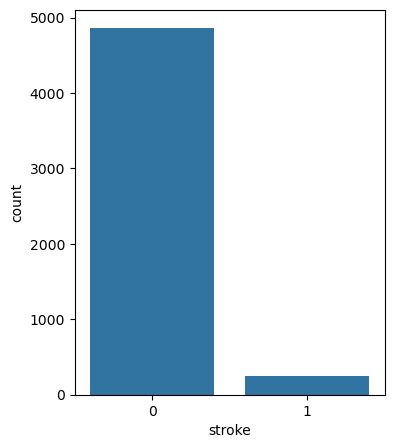

stroke
0    95.127202
1     4.872798
Name: proportion, dtype: float64


In [6]:
plt.figure(figsize = (4,5))
sns.countplot(x = 'stroke', data = sk)
plt.xlabel('stroke')
plt.ylabel('count')
plt.show()
print(sk.stroke.value_counts(normalize = True) * 100)

# Stroke Prediction Project

This project aims to predict stroke risk using the `stroke-data.csv` dataset from Kaggle. Due to the rarity of stroke cases, we will address class imbalance and focus on metrics like **Recall** and **ROC-AUC** to ensure high-risk patients are identified. Key steps include:
- Data cleaning and feature selection
- Model training and evaluation
- Emphasis on clinical usefulness

The goal is to create a reliable tool for early stroke risk detection.

In [7]:
sk.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [8]:
sk.duplicated().sum()

np.int64(0)

In [9]:
sk['bmi'] = sk['bmi'].fillna(sk.bmi.median())

In [10]:
sk.stroke.value_counts()

stroke
0    4861
1     249
Name: count, dtype: int64

In [11]:
sk.stroke.value_counts(normalize = True) * 100

stroke
0    95.127202
1     4.872798
Name: proportion, dtype: float64

## Exploratory Data Analysis
The dataset contains **5110 records** and **12 columns**: `id`, `gender`, `age`, `hypertension`, `heart_disease`, `ever_married`, `work_type`, `Residence_type`, `avg_glucose_level`, `bmi`, `smoking_status`, `stroke`. Key observations:
- **Missing Values**: The `bmi` column has 201 missing entries (4909 non-null out of 5110). The `smoking_status` column includes an `Unknown` category that may need handling.
- **Class Imbalance**: Approximately 4.87% of records have `stroke=1` (249/5110), indicating a significant class imbalance that requires techniques like SMOTE for modeling.
  

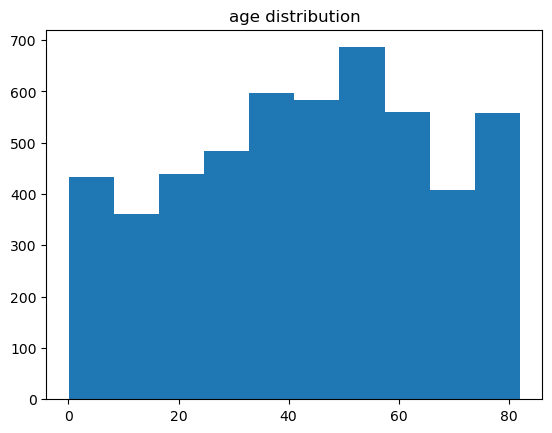

In [12]:
plt.title('age distribution')
plt.hist(sk.age)
plt.show()

stroke
0    4861
1     249
Name: count, dtype: int64


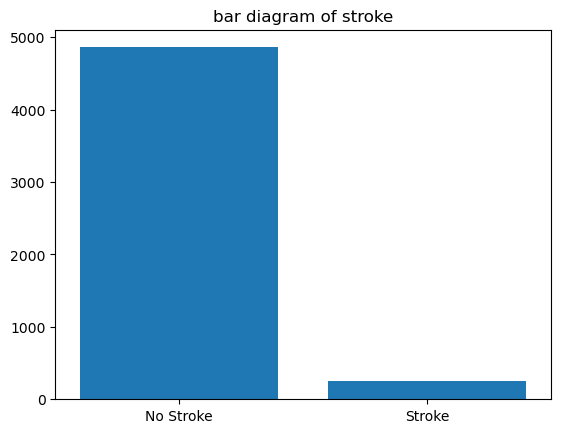

In [13]:
stroke_counts = sk.stroke.value_counts()
print(stroke_counts)

plt.title('bar diagram of stroke')
plt.bar(stroke_counts.index , stroke_counts.values)
plt.xlim(-0.5, 1.5)
plt.xticks(stroke_counts.index, ['No Stroke', 'Stroke'])  # Custom labels for 0 and 1
plt.show()

In [ ]:
encoded_sk = sk.copy()

le = LabelEncoder()
encoded_sk['gender'] = le.fit_transform(encoded_sk['gender'])
encoded_sk['ever_married'] = le.fit_transform(encoded_sk['ever_married'])
encoded_sk['Residence_type'] = le.fit_transform(encoded_sk['Residence_type'])

joblib.dump('..\\model\\label_encoder.joblib')
encoded_sk = pd.get_dummies(encoded_sk , columns = ['work_type','smoking_status'], drop_first = True)

encoded_sk = encoded_sk.drop('id' , axis = 1)

print('Encoded dataframe shape:', encoded_sk.shape)
print(encoded_sk.head())

Encoded dataframe shape: (5110, 16)
   gender   age  hypertension  heart_disease  ever_married  Residence_type  \
0       1  67.0             0              1             1               1   
1       0  61.0             0              0             1               0   
2       1  80.0             0              1             1               0   
3       0  49.0             0              0             1               1   
4       0  79.0             1              0             1               0   

   avg_glucose_level   bmi  stroke  work_type_Never_worked  work_type_Private  \
0             228.69  36.6       1                   False               True   
1             202.21  28.1       1                   False              False   
2             105.92  32.5       1                   False               True   
3             171.23  34.4       1                   False               True   
4             174.12  24.0       1                   False              False   

   work_

In [15]:
encoded_sk['age_hypertension'] = encoded_sk['age'] * encoded_sk['hypertension']
encoded_sk['age_heart_disease'] = encoded_sk['age'] * encoded_sk['heart_disease']
print('shape of dataframe after feature engineering', encoded_sk.shape)

shape of dataframe after feature engineering (5110, 18)


In [16]:
encoded_sk.stroke.value_counts(normalize = True) * 100
encoded_sk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   gender                          5110 non-null   int64  
 1   age                             5110 non-null   float64
 2   hypertension                    5110 non-null   int64  
 3   heart_disease                   5110 non-null   int64  
 4   ever_married                    5110 non-null   int64  
 5   Residence_type                  5110 non-null   int64  
 6   avg_glucose_level               5110 non-null   float64
 7   bmi                             5110 non-null   float64
 8   stroke                          5110 non-null   int64  
 9   work_type_Never_worked          5110 non-null   bool   
 10  work_type_Private               5110 non-null   bool   
 11  work_type_Self-employed         5110 non-null   bool   
 12  work_type_children              51

correlation with stroke:
 age                               0.245257
age_hypertension                  0.149634
age_heart_disease                 0.142783
heart_disease                     0.134914
avg_glucose_level                 0.131945
hypertension                      0.127904
ever_married                      0.108340
work_type_children                0.083869
smoking_status_formerly smoked    0.064556
work_type_Self-employed           0.062168
bmi                               0.036110
Residence_type                    0.015458
work_type_Never_worked            0.014882
work_type_Private                 0.011888
smoking_status_smokes             0.008939
gender                            0.008929
smoking_status_never smoked       0.004129
Name: stroke, dtype: float64
figure saved


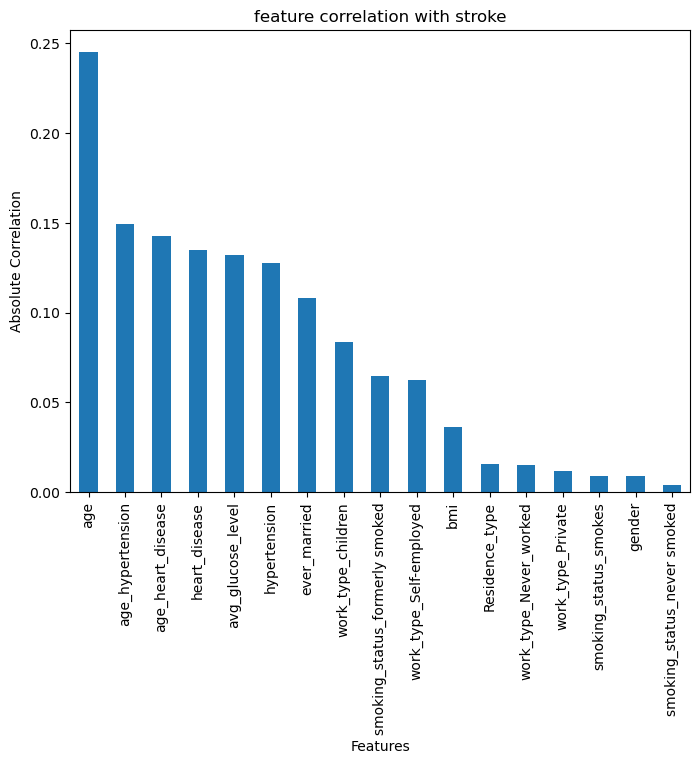

In [17]:
corr_matrix = encoded_sk.corr()
stroke_matrix = corr_matrix.stroke.drop('stroke')
sorted_matrix = stroke_matrix.abs().sort_values(ascending = False)
print('correlation with stroke:\n',sorted_matrix)

plt.figure(figsize = (8,6))
sorted_matrix.plot(kind = 'bar')
plt.title('feature correlation with stroke')
plt.xlabel('Features')
plt.ylabel('Absolute Correlation')
plt.savefig('..\\visualization\\stroke_correlation')
print('figure saved')
plt.show()

In [18]:
print('top 3 predictors are: \n' , sorted_matrix.head(3))

top 3 predictors are: 
 age                  0.245257
age_hypertension     0.149634
age_heart_disease    0.142783
Name: stroke, dtype: float64


In [19]:
encoded_sk.to_csv('..\\data\\processed_stroke_data.csv', index = False)
print('Processed_data_saved with shape:', encoded_sk.shape)

Processed_data_saved with shape: (5110, 18)


In [20]:
processed_df = pd.read_csv('..\\data\\processed_stroke_data.csv')

print(processed_df.shape)
print(processed_df.columns)
print(processed_df.info())

(5110, 18)
Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'Residence_type', 'avg_glucose_level', 'bmi', 'stroke',
       'work_type_Never_worked', 'work_type_Private',
       'work_type_Self-employed', 'work_type_children',
       'smoking_status_formerly smoked', 'smoking_status_never smoked',
       'smoking_status_smokes', 'age_hypertension', 'age_heart_disease'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   gender                          5110 non-null   int64  
 1   age                             5110 non-null   float64
 2   hypertension                    5110 non-null   int64  
 3   heart_disease                   5110 non-null   int64  
 4   ever_married                    5110 non-null   int64  
 5   Residence_type                  5110

In [21]:
X = processed_df.drop('stroke', axis = 1)
y = processed_df['stroke']

x_train, x_test, y_train, y_test = train_test_split(X, y, random_state = 42, train_size = 0.8, stratify = y)
print('y_train shape',y_train.value_counts())
print('y_test shape',y_test.value_counts())

smote = SMOTE(random_state = 42)
x_train_sampled , y_train_sampled = smote.fit_resample(x_train,y_train)
print(' \nafter applying SMOTE \n')
print('y_train sampled',y_train_sampled.value_counts())
print('y_train sampled shape',y_train_sampled.shape)


y_train shape stroke
0    3889
1     199
Name: count, dtype: int64
y_test shape stroke
0    972
1     50
Name: count, dtype: int64
 
after applying SMOTE 

y_train sampled stroke
0    3889
1    3889
Name: count, dtype: int64
y_train sampled shape (7778,)


In [22]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler

columns_to_scale = ['age', 'avg_glucose_level', 'bmi','age_hypertension','age_heart_disease']

preprocessor = ColumnTransformer(
    transformers = [
        ('scaler', MinMaxScaler(), columns_to_scale)
    ],
    remainder = 'passthrough'
)

scaled_x_train = preprocessor.fit_transform(x_train_sampled)
scaled_x_test = preprocessor.transform(x_test)

joblib.dump(preprocessor,'..\\model\\preprocessor.joblib')

print('x_train scaled shape',scaled_x_train.shape)
print('x_test scaled shape',scaled_x_test.shape)

x_train scaled shape (7778, 17)
x_test scaled shape (1022, 17)


In [23]:
svc = SVC(kernel = 'rbf', probability = True, random_state = 42)
knc = KNeighborsClassifier(n_neighbors = 5)
lrc = LogisticRegression(solver = 'liblinear', penalty = 'l1' , class_weight = 'balanced')
rfc = RandomForestClassifier(n_estimators = 100, random_state = 42 , class_weight = 'balanced')
xgb = XGBClassifier(n_estimators = 100, random_state = 42, scale_pos_weight = 10)

In [24]:
models = {
    'SVC' : svc,
    'KNC' : knc,
    'LRC' : lrc,
    'RFC' : rfc,
    'XGB' : xgb
}

In [ ]:


from sklearn.metrics import recall_score, roc_auc_score

def train_model(model, x_train_sampled, y_train_sampled, scaled_x_test, y_test):
    model.fit(x_train_sampled, y_train_sampled)
    y_pred = model.predict(scaled_x_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    roc_auc = roc_auc_score(y_test, model.predict_proba(scaled_x_test)[:, 1]) if hasattr(model, "predict_proba") else None
    return accuracy, precision, recall, roc_auc, y_pred

In [26]:
results = {}
for name, model in models.items():
    accuracy ,precision ,recall, roc_auc, y_pred= train_model(model, scaled_x_train, y_train_sampled, scaled_x_test, y_test)
    results[name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'ROC-AUC': roc_auc
    }
    print('\nfor', name)
    print('confusion matrix: \n',confusion_matrix(y_test,y_pred))
    print('accuracy score: ', accuracy)
    print('precision score: ', precision)
    print('recall: ', recall)
    print('ROC-AUC', roc_auc)

print('')
results_df = pd.DataFrame(results).T
print(results_df)


for SVC
confusion matrix: 
 [[868 104]
 [ 27  23]]
accuracy score:  0.8718199608610567
precision score:  0.18110236220472442
recall:  0.46
ROC-AUC 0.7830658436213992

for KNC
confusion matrix: 
 [[859 113]
 [ 31  19]]
accuracy score:  0.8590998043052838
precision score:  0.14393939393939395
recall:  0.38
ROC-AUC 0.6642181069958847

for LRC
confusion matrix: 
 [[818 154]
 [ 21  29]]
accuracy score:  0.8287671232876712
precision score:  0.15846994535519127
recall:  0.58
ROC-AUC 0.7983333333333333

for RFC
confusion matrix: 
 [[926  46]
 [ 39  11]]
accuracy score:  0.9168297455968689
precision score:  0.19298245614035087
recall:  0.22
ROC-AUC 0.7904012345679012

for XGB
confusion matrix: 
 [[886  86]
 [ 34  16]]
accuracy score:  0.8825831702544031
precision score:  0.1568627450980392
recall:  0.32
ROC-AUC 0.7801234567901234

     Accuracy  Precision  Recall   ROC-AUC
SVC  0.871820   0.181102    0.46  0.783066
KNC  0.859100   0.143939    0.38  0.664218
LRC  0.828767   0.158470    0.58  0.

In [29]:
params_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0]
}

xgb = XGBClassifier(random_state = 42, scale_pos_weight=10)
grid_search = GridSearchCV(xgb, params_grid, cv = 5, scoring= 'roc_auc', n_jobs = -1)
grid_search.fit(scaled_x_train,y_train_sampled)

best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(scaled_x_test)
print('best parameter: ',grid_search.best_params_)
print('best ROC-AUC (CV):',grid_search.best_score_)
print('\nbest model')
print('confusion matrix:\n',confusion_matrix(y_test, y_pred_best))
print(classification_report(y_test,y_pred_best))
print(f'ROC-AUC: {roc_auc_score(y_test, best_model.predict_proba(scaled_x_test)[:, 1]):.4f}')

joblib.dump(best_model,'..\\model\\fine_tunned_xgbclassifier.joblib')

best parameter:  {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}
best ROC-AUC (CV): 0.9934163672465031

best model
confusion matrix:
 [[886  86]
 [ 36  14]]
              precision    recall  f1-score   support

           0       0.96      0.91      0.94       972
           1       0.14      0.28      0.19        50

    accuracy                           0.88      1022
   macro avg       0.55      0.60      0.56      1022
weighted avg       0.92      0.88      0.90      1022

ROC-AUC: 0.7891


['..\\model\\fine_tunned_xgbclassifier.joblib']